### Do all hyperparameters enable a successful fit?

In [1]:
from pathlib import Path
import sys
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pypesto 
import pypesto.visualize as vis

dir_pipeline = Path(".").resolve().parents[1]
dir_1 = dir_pipeline / "1_mechanistic_model"
dir_6 = Path(".").resolve().parent
sys.path.append(str(dir_1))
sys.path.append(str(dir_6))

from helpers_ruoff import load_exp_summary

In [2]:
## manual setting ##
problem_name = "ruoff_atp_consumption"
experiment_name_grid = "2024_07_22_Ruoff_Grid"
experiment_name_25 = "2024_08_13_Ruoff_Grid"
CLUSTER = False

In [3]:
# set paths
if CLUSTER:
    storage_dir = Path("/storage/groups/hasenauer_lab/sym/").resolve()
    dir_5 = storage_dir / "5_optimisation"
    dir_sim = storage_dir / "6_evaluation" / "simulation"
else:
    dir_5 = dir_pipeline / "5_optimisation"

from reference_ruoff import PARAMETERS_IDS
with open(dir_pipeline / "problems.json", "r") as f:
    problem = json.load(f)["ruoff_atp_consumption"]

ordered_parameter_names = [p for p, i in zip(PARAMETERS_IDS, problem["mechanistic_parameters"]) if i]

In [4]:
hps_categorical = ['hidden_layers', 'hidden_neurons', 'act_fct', 'nn_input_normalization', 'reg']
hps_continuous = ['λ_reg', 'lr_adam']
noise_parameters = ["sd_N_2_obs", "sd_A_3_obs"]

Load both Ruoff experiments, bin the continunous hyperparameters

In [5]:
summary_grid = load_exp_summary(dir_5 / experiment_name_grid)
summary_25 = load_exp_summary(dir_5 / experiment_name_25)
# combine
summary = pd.concat([summary_25, summary_grid])

# create the output dir
dir_output = Path(".") / f"hps_in_success"
dir_output.mkdir(exist_ok=True, parents=True)

# add reg bins
bins_reg = [-1, 1e-4,    1e-2,  1e-1,   1,   10]
labels_reg = ["0", "<0.01", "<0.1", "<1", "<10"]
summary["regbin"] = pd.cut(summary['λ_reg'], bins=bins_reg, labels=labels_reg)

# add learning rate bins
bins_lr = [1e-4,   1e-3,    1e-2,    1e-1]
labels_lr = ["<0.001", "<0.01", "<0.1"]
summary["lr_bin"] = pd.cut(summary['lr_adam'], bins=bins_lr, labels=labels_lr)

hp_binned = ["regbin", "lr_bin"]

# add reg yes/no column
summary["reg"] = summary["λ_reg"].apply(lambda x: int(bool(x)))

# add a column indicating ANN width x depth
summary["ann_dim"] = summary[
    "hidden_layers"
].astype(str) + " x " + summary[
    "hidden_neurons"
].astype(str)

hps_categorical = list(set(hps_categorical + ["reg", "ann_dim"]))

### Hyperparameters in successful fits

In [6]:
metric = 'nmae_obs_test'
threshold = 0.15

dir_output_threshold = dir_output / (metric + "_" + str(threshold).replace(".", "_"))
dir_output_threshold.mkdir(exist_ok=True)

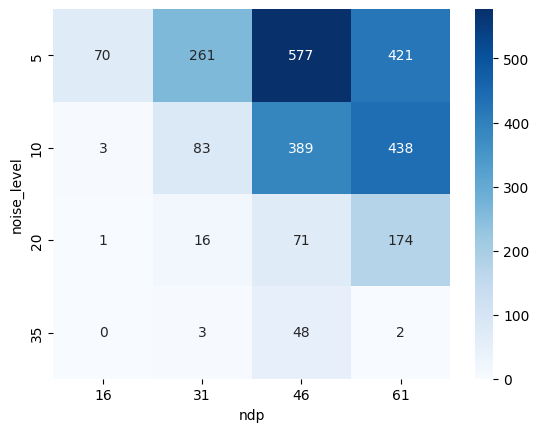

In [7]:
success = summary[summary[metric] < threshold]
success_grid = success[["noise_level", "ndp"]].value_counts().reset_index().pivot_table(
    values="count", index="noise_level", columns="ndp"
).replace({np.nan: 0})
sns.heatmap(success_grid, cmap="Blues", annot=True, fmt=".0f")
plt.savefig(dir_output_threshold / "heatmap_successful_fits.svg")

- Number of good fits increases with the number of datapoints and decreasing noise, except:
- for 5% and 35% noise: 46 data points are better than 61.
- At 61 data points: 10% noise is better than 5% noise.

/tmp/ipykernel_1186632/545111143.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1186632/545111143.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1186632/545111143.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1186632/545111143.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1186632/545111143.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


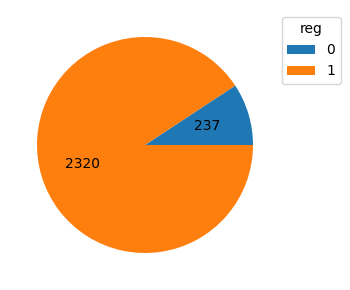

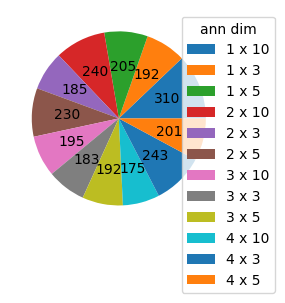

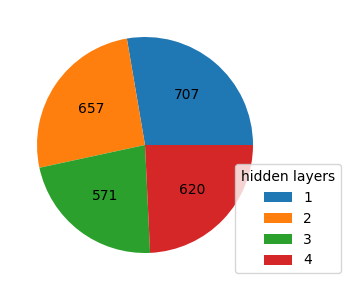

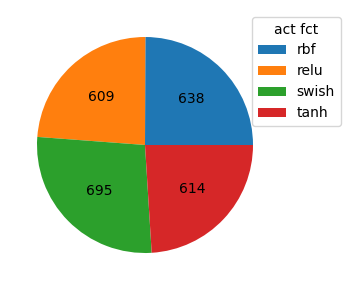

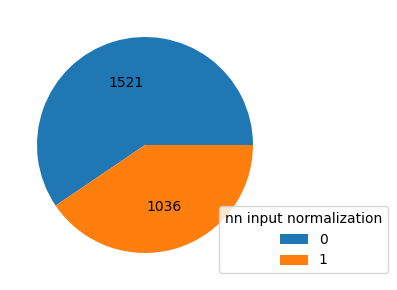

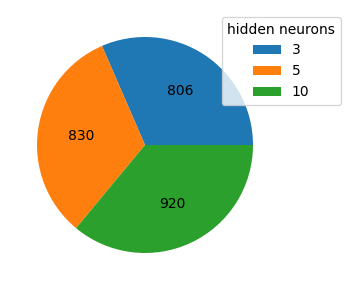

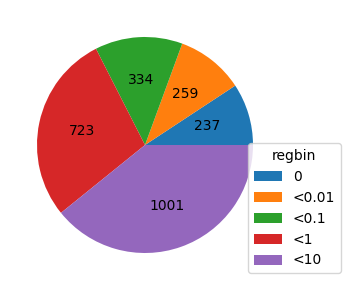

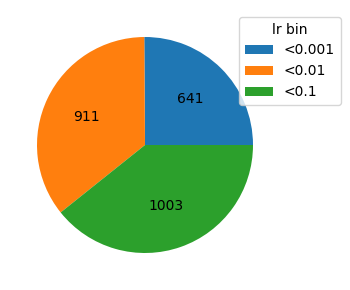

In [8]:
for hp in hps_categorical + hp_binned:
    fig, ax = plt.subplots(figsize=(5, 3))
    # calc and sort the # fits/hp setting
    hp2plot = success[hp].value_counts().sort_index()

    def absolute_value(val):
        a  = int(val/100.*hp2plot.values.sum())
        return a

    wedges, texts, autotexts = ax.pie(
        hp2plot.values, autopct=absolute_value,
    )
    ax.legend(
        wedges, hp2plot.index,
        title=hp2plot.index.name.replace("_", " "),
        bbox_to_anchor=(0.75, 0, 0.5, 1)
    )
    fig.show()
    fig.tight_layout()
    fig.savefig(dir_output_threshold / f"pie_{hp}.svg", transparent=True)